<a href="https://colab.research.google.com/github/norahhaque/Spam-Message-Detection/blob/main/Spam_Message_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##1. Binary Clustering

Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import nltk.stem
import matplotlib.pyplot as plt
import plotly.express as px
import scipy.sparse
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from wordcloud import WordCloud

Retrieving and storing our message data

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/sziccardi/CSCI4521_DataRepository/refs/heads/main/sms_spam_cleaned.csv")

In [ ]:
messages = df["msg"].tolist()
labels = df["type"]

Vectorize documents with TF-IDF Vectorizer with Stemming

In [ ]:
english_stemmer = nltk.stem.SnowballStemmer('english')
class StemmedTfidfVectorizer(TfidfVectorizer):
   def build_analyzer(self):
     analyzer = super(StemmedTfidfVectorizer, self).build_analyzer()
     return lambda doc: (english_stemmer.stem(w) for w in analyzer(doc))

vectorizer = StemmedTfidfVectorizer(min_df=1, stop_words='english')
X = vectorizer.fit_transform(messages)

Finding an optimal K number of clusters!

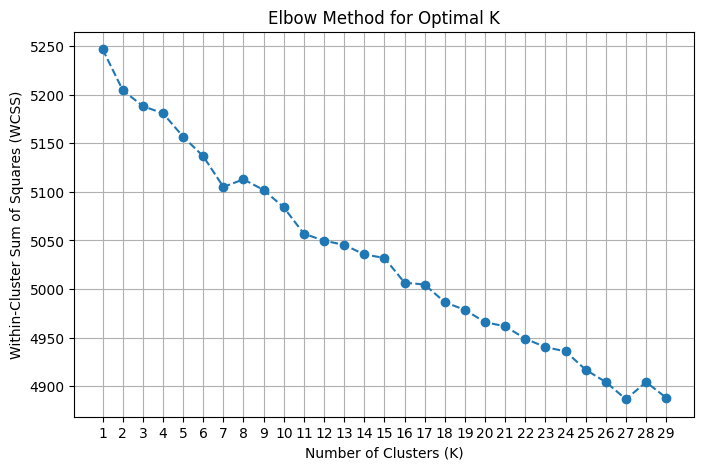

In [ ]:
K_values = np.arange(1, 30, 1)
within_cluster_sum_squares = []

for k in K_values:
    km = KMeans(n_clusters=k, init='random', n_init=10, random_state=42)
    km.fit(X)

    inertia = km.inertia_
    within_cluster_sum_squares.append(inertia)

plt.figure(figsize=(8, 5))
plt.plot(K_values, within_cluster_sum_squares, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal K')
plt.xticks(K_values)
plt.grid(True)
plt.show()


The graph of WCSS shows a steep decline up until k = 12, after which the slope started to flatten out. This indicates that adding more clusters beyond 12 no longer significantly improves the model, making k = 12 the optimal choice for the number of clusters.

In [ ]:
km = KMeans(n_clusters=12, init='random', n_init=10)
km.fit(X)

KMeans(init='random', n_clusters=12, n_init=10)

In [ ]:
df["cluster"] = km.labels_
spam_counts = df.query('type == "spam"')["cluster"].value_counts()
ham_counts = df.query('type == "ham"')["cluster"].value_counts()

print("Spam counts: ")
print(spam_counts)
print("\nHam counts: ")
print(ham_counts)

Spam counts: 
cluster
3     234
7     161
2     160
1      60
10     34
9      18
8       8
5       6
11      5
Name: count, dtype: int64

Ham counts: 
cluster
7     3295
9      334
11     209
8      178
0      173
10     134
5       76
3       72
1       60
6       56
2       21
4       10
Name: count, dtype: int64


Finding clusters where almost no messages are spam (majority ham) and clusters where many are spam (majority spam).

In [ ]:
majority_spam = spam_counts.index[[0, 2]].tolist()
majority_ham = ham_counts.index[1:3].tolist()

print("Majority Spam Clusters:", majority_spam)
print("Majority Ham Clusters:", majority_ham)

Majority Spam Clusters: [3, 2]
Majority Ham Clusters: [9, 11]


Helper functions to analzye our clusters!

In [ ]:
feature_names = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(X.todense(), columns=feature_names)

def generate_word_clouds_for_clusters(clusters):
    for cluster_id in clusters:
        matching_indices = (km.labels_ == cluster_id)

        word_tfidf = tfidf_df[matching_indices].T.sum(axis=1)

        word_cloud = WordCloud(
            collocations=False,
            background_color='white',
            max_words=60,
            width=2048,
            height=1080
        ).generate_from_frequencies(word_tfidf)

        plt.imshow(word_cloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()

        print(f"Cluster {cluster_id} size: ", np.sum(matching_indices))
        print("\n".join(txt for txt in np.random.choice(np.array(labels)[matching_indices], 10)))
        print("\n")


def sample_msg(cluster_ids):
  for cluster_id in cluster_ids:
        cluster_df = df[df['cluster'] == cluster_id]
        sample_messages = cluster_df['msg'].sample(n=2, random_state=10)

        print(f"Cluster {cluster_id} messages:")
        print("\n".join(sample_messages))
        print("\n")


def calculate_spam_percentage(cluster_ids):
    for cluster_id in cluster_ids:
        cluster_df = df[df['cluster'] == cluster_id]
        total_messages = len(cluster_df)
        spam_messages = len(cluster_df[cluster_df['type'] == 'spam'])
        spam_percentage = (spam_messages / total_messages) * 100 if total_messages > 0 else 0

        print(f"  Spam percentage: {spam_percentage:.2f}%")



###Analysis of Majority Spam Clusters:

Spam Word Clouds

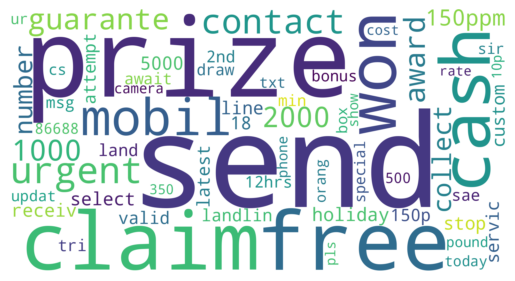

Cluster 3 size:  306
spam
ham
spam
ham
spam
ham
ham
spam
ham
ham




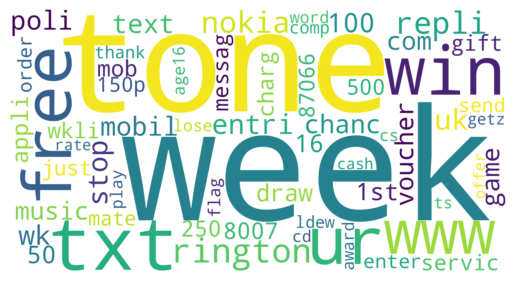

Cluster 2 size:  181
spam
spam
spam
spam
spam
spam
spam
spam
spam
spam




In [ ]:
generate_word_clouds_for_clusters(majority_spam)

Spam Representative Messages

In [ ]:
sample_msg(majority_spam)

Cluster 3 messages:
4mths half price Orange line rental & latest camera phones 4 FREE. Had your phone 11mths ? Call MobilesDirect free on 08000938767 to update now! or2stoptxt
Hi Chikku send some nice msgs


Cluster 2 messages:
Ur TONEXS subscription has been renewed and you have been charged £4.50. You can choose 10 more polys this month. www.clubzed.co.uk *BILLING MSG*
Dear Voucher Holder To claim this weeks offer at your PC please go to http://www.wtlp.co.uk/text. Ts&Cs apply.




Percentage Spam

In [ ]:
calculate_spam_percentage(majority_spam)

  Spam percentage: 76.47%
  Spam percentage: 88.40%


Outliers in Majority Spam Cluster

In [ ]:
ham_outliers = df[(df['cluster'] == majority_spam[0]) & (df['type'] == 'ham')]
random_ham_messages = ham_outliers['msg'].sample(n=3, random_state=10)
print("Ham messages in spam cluster:\n")
print("\n".join(random_ham_messages))


Ham messages in spam cluster:

She.s fine. I have had difficulties with her phone. It works with mine. Can you pls send her another friend request.
I think i've fixed it can you send a test message?
I dont. Can you send it to me. Plus how's mode.


These ham messages probably ended up in the majority spam cluster because of their informal language and use of certain words. Things like "Can you send it to me" and "send another friend request" might have triggered the algorithm since spam often involves asking for things or making unclear requests. Plus, the use of terms like "phone" and "test message" could have triggered the model to see the messages as more "spam-like".

###Analysis of Majority Ham Clusters:

Ham Word Clouds:

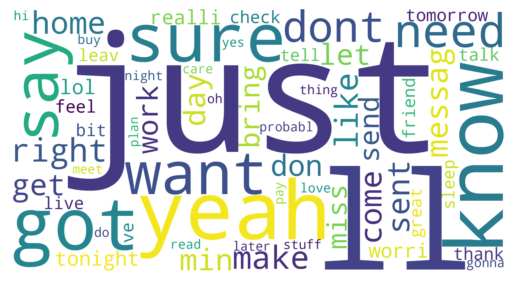

Cluster 9 size:  352
ham
ham
ham
ham
ham
ham
ham
ham
ham
ham




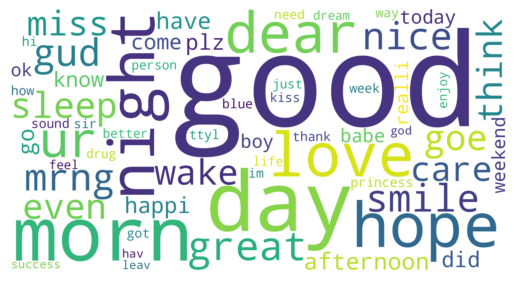

Cluster 11 size:  214
ham
ham
ham
ham
ham
ham
ham
ham
ham
ham




In [ ]:
generate_word_clouds_for_clusters(majority_ham)

Ham Representative Messages

In [ ]:
sample_msg(majority_ham)

Cluster 9 messages:
Alright we'll bring it to you see you in like ### mins
That sucks. I'll go over so u can do my hair. You'll do it free right?


Cluster 11 messages:
Each Moment in a dayhas its own value-Morning brings hopeafternoon brings faithEvening brings luvNight brings restWish u find them all today.Good Morning ham	### w jetton ave if you forgot
TODAY is Sorry day.! If ever i was angry with you if ever i misbehaved or hurt you? plz plz JUST SLAP URSELF Bcoz Its ur fault I'm basically GOOD




Percentage Spam

In [ ]:
calculate_spam_percentage(majority_ham)

  Spam percentage: 5.11%
  Spam percentage: 2.34%


Outliers in Majority Ham Cluster

In [ ]:
spam_outliers = df[(df['cluster'] == majority_ham[1]) & (df['type'] == 'spam')]
if (len(spam_outliers) >= 3):
  spam_messages = spam_outliers['msg'].sample(n=3)
else:
  spam_messages = spam_outliers['msg']
print("Spam messages in cluster 10:\n")
print("\n".join(spam_messages))


Spam messages in cluster 10:

For sale - arsenal dartboard. Good condition but no doubles or trebles!
Good Luck! Draw takes place 28th Feb 06. Good Luck! For removal send STOP to 87239 customer services 08708034412
Ever thought about living a good life with a perfect partner? Just txt back NAME and AGE to join the mobile community. (100p/SMS)


These spam messages might have ended up in the ham cluster because their structure and phrasing is more generic. Phrases like “Good Luck!” and “customer services” might have been common in ham messages like regular promotional messages or notifications. Additionally, the lack of alarming language (e.g., "urgent" or "win now") may have caused the algorithm to miss the spam indicators.

###Let's test on some new messages!

In [ ]:
new_messages = ["Congratulations! Amazon has gifted you a $1000 gift card for your loyalty!",
                "Claim your free vacation from Expedia, no purchase required. Limited offering only.",
                "hey when are you getting home babe",
                "sry missed your call when can i call you back?"
              ]

new_vectors = vectorizer.transform(new_messages)

cos_similarities = cosine_similarity(new_vectors, km.cluster_centers_)

for i, message in enumerate(new_messages):
    closest_cluster = np.argmax(cos_similarities[i])
    print(f"Message: {message}")
    print(f"Closest cluster: {closest_cluster}")
    print("-" * 40)


Message: Congratulations! Amazon has gifted you a $1000 gift card for your loyalty!
Closest cluster: 3
----------------------------------------
Message: Claim your free vacation from Expedia, no purchase required. Limited offering only.
Closest cluster: 3
----------------------------------------
Message: hey when are you getting home babe
Closest cluster: 7
----------------------------------------
Message: sry missed your call when can i call you back?
Closest cluster: 7
----------------------------------------


The clustering performed as expected! The closest cluster to both the spam messages was Cluster 3, a majority spam group while the ham messages were closest to Cluster 7, a majority ham group.

**Extra Credit: Updated Word Cloud!**

In [ ]:
from PIL import Image
def generate_non_rectangular_word_clouds_for_clusters(clusters, mask_image_path, max_words=20):
    for cluster_id in clusters:
        matching_indices = (km.labels_ == cluster_id)

        word_tfidf = tfidf_df[matching_indices].T.sum(axis=1)


        mask = np.array(Image.open(mask_image_path))

        word_cloud = WordCloud(
            collocations=False,
            background_color='white',
            width=2048,
            height=1080,
            mask=mask,
            contour_width=3,
            contour_color='black',
            colormap='ocean'
        ).generate_from_frequencies(word_tfidf)

        plt.imshow(word_cloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
        plt.savefig(f"wordcloud_cluster_{cluster_id}_high_res.png", dpi=300)

        print(f"Cluster {cluster_id}")
        print("\n")


Spam Word Clouds (non-rectangular)

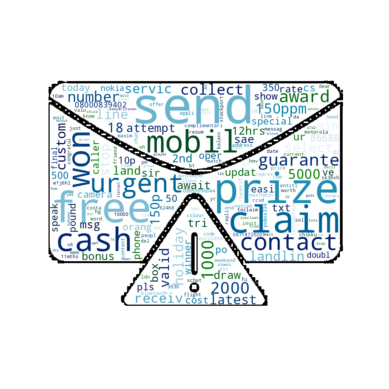

Cluster 3




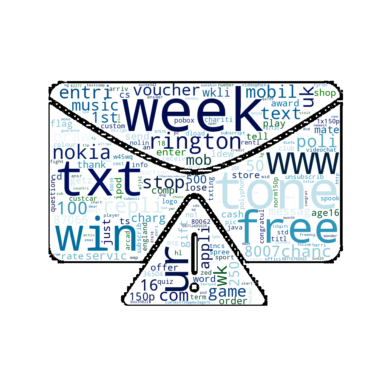

Cluster 2




<Figure size 640x480 with 0 Axes>

In [ ]:
generate_non_rectangular_word_clouds_for_clusters(majority_spam, mask_image_path="spam.jpg")

Ham Word Clouds (non-rectangular)

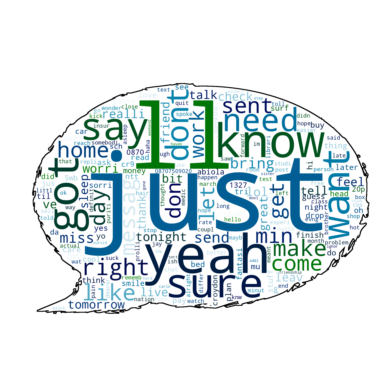

Cluster 9




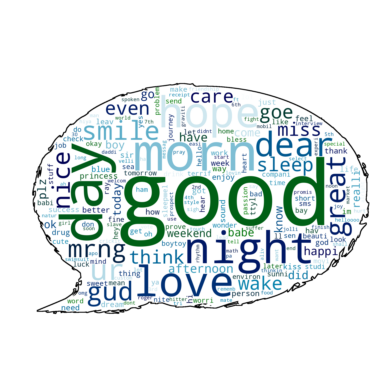

Cluster 11




<Figure size 640x480 with 0 Axes>

In [ ]:
generate_non_rectangular_word_clouds_for_clusters(majority_ham, mask_image_path="txt.png")

## 3. PCA

In [ ]:
pca = PCA(n_components=3)
pc = pca.fit_transform(X)

In [ ]:
pca_df = pd.DataFrame(pc, columns=['PC1', 'PC2', 'PC3'])
pca_df['Cluster'] = km.labels_
pca_df['ID'] = range(len(df))
pca_df["Type"] = df["type"]

fig = px.scatter_3d(pca_df, x="PC1", y="PC2", z="PC3", color = 'Type', hover_data=["ID", "Cluster"])
fig.show()

Spam Points Far Away from other Spam Points:

In [ ]:
print(messages[4041])

accordingly. I repeat just text the word ok on your mobile phone and send


In [ ]:
print(messages[3187])

Sorry I missed your call let's talk when you have the time. I'm on 07090201529


These spam messages are further away from the other spam points because their language and structure differ from the majority of spam messages. The first message uses unusual phrasing and lacks the typical high-frequency words associated with spam, like "free" or "prize." The repetition and instruction may be also be less common in other spam messages.

Similarly, the second message is uncommon in standard spam which often uses more generic offers or links. Although both these texts are still spam, these subtle differences make the points more distant from the rest of the spam cluster as they don't match the usual patterns PCA has learned from other spam messages.

Ham Points Far Away from other Ham Points:

In [ ]:
print(messages[4529])

Hi.:)technical support.providing assistance to us customer through call and email:)


In [ ]:
print(messages[4610])

S.this will increase the chance of winning.


These ham messages are further away from other ham points in the PCA space because they have unusual phrasing or structure compared to typical ham texts. The first message is awkwardly worded and has excessive punctuation, making it different from the more casual conversations that dominate the ham cluster. It also mentions "technical support," a term more commonly associated with spam. The second message, "S.this will increase the chance of winning," is vague and includes the word "winning," which could make it seem more like spam even though its intended as informational. In the PCA, these irregularities in language don't align with the main patterns that define typical ham messages, causing them to be projected further away from the core ham cluster.

In [ ]:
num_features = X.shape[1]
print(f"Total number of features in the dataset: {num_features}")

pca = PCA(n_components=350)
X_pc = pca.fit_transform(X)

exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

fig = px.line(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Cumulative Explained Variance"},
    title="Cumulative Explained Variance vs. Number of Components"
)

fig.show()


Total number of features in the dataset: 6859


By the graph in the above cell, 322 principal components are neded to capture just over 50% of the variation in the dataset features.

## 4. Dimensionality Reduction and Classification

Implementing a 1-nearest neighbor classifier that uses the full vectorized features directly.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.33)

In [ ]:
%%time
X_train = X_train.toarray() if scipy.sparse.issparse(X_train) else X_train
X_test = X_test.toarray() if scipy.sparse.issparse(X_test) else X_test

pred = []
for test_feature in X_test:
  dist = [np.linalg.norm((test_feature - train_feature)) for train_feature in X_train]
  best_idx = np.argmin(dist)
  pred.append(y_train.iloc[best_idx])

CPU times: user 1min 13s, sys: 354 ms, total: 1min 13s
Wall time: 1min 14s


Let's see how it did!

In [ ]:
acc = (pred==y_test).sum()/y_test.size
TP = np.sum((pred == "spam") & (y_test == "spam"))
FP = np.sum((pred == "spam") & (y_test == "ham"))
FN = np.sum((pred == "ham") & (y_test == "spam"))

precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print("Classification accuracy is",acc,"\n")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}\n")

Classification accuracy is 0.9331810394060537 

Precision: 1.000
Recall: 0.506
F1-Score: 0.672



Implementing a 1-nearest-neighbor classifier that uses the top-K PCA components as features.

Let's find a K!

In [ ]:
pca = PCA(n_components=101)
X_train_pc = pca.fit_transform(X_train)
X_test_pc = pca.transform(X_test)

In [ ]:
dims = np.arange(1,40,5)
accuracy = []

for dim in dims:

  pred = []
  for test_feature in X_test_pc[:,0:dim]:
    dist = [np.linalg.norm((test_feature - train_feature[:dim])) for train_feature in X_train_pc[:,0:dim]]
    best_idx = np.argmin(dist)
    pred.append(y_train.iloc[best_idx])

  acc = (pred==y_test).sum()/y_test.size
  accuracy += [acc]
  print("With",dim,"PCs the accuracy is",acc)

With 1 PCs the accuracy is 0.8372358652198744
With 6 PCs the accuracy is 0.9640205596801827
With 11 PCs the accuracy is 0.9657338663620788
With 16 PCs the accuracy is 0.963449457452884
With 21 PCs the accuracy is 0.960022844089092
With 26 PCs the accuracy is 0.9565962307252999
With 31 PCs the accuracy is 0.9588806396344945
With 36 PCs the accuracy is 0.9623072529982867


Because accuracy peaks at 11 principal components at 0.966 before dropping down again to 0.963 with 16 PCS, 11 components is the optimal choice for the top-K PCA components.



Running our 1-NN Classifier with 11 PCS

In [ ]:
components=11
pca = PCA(n_components=components)
X_train_pc = pca.fit_transform(X_train)
X_test_pc = pca.transform(X_test)
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)
print("Variance explained by",n_components,"PCA components:", exp_var_cumul[-1])


Variance explained by 11 PCA components: 0.06462962420210637


In [ ]:
%%time
pred = []
for test_feature in X_test_pc:
  dist = [np.linalg.norm((test_feature - train_feature)) for train_feature in X_train_pc]
  best_idx = np.argmin(dist)
  pred.append(y_train.iloc[best_idx])

CPU times: user 28.1 s, sys: 614 ms, total: 28.7 s
Wall time: 30.7 s


Let's see how it did!

In [ ]:
acc_pca = (pred==y_test).sum()/y_test.size
pred_pca = np.array(pred)

TP_pca = np.sum((pred_pca == "spam") & (y_test == "spam"))
FP_pca = np.sum((pred_pca == "spam") & (y_test == "ham"))
FN_pca = np.sum((pred_pca == "ham") & (y_test == "spam"))
precision_pca = TP_pca / (TP_pca + FP_pca) if (TP_pca + FP_pca) > 0 else 0
recall_pca = TP_pca / (TP_pca + FN_pca) if (TP_pca + FN_pca) > 0 else 0
f1_pca = 2 * (precision_pca * recall_pca) / (precision_pca + recall_pca) if (precision_pca + recall_pca) > 0 else 0

print("1-NN Classifier ("+str(components)+"PCs) -- Accuracy is:",acc)
print(f"Precision: {precision_pca:.3f}")
print(f"Recall: {recall_pca:.3f}")
print(f"F1-Score: {f1_pca:.3f}")
print("")

1-NN Classifier (11PCs) -- Accuracy is: 0.9623072529982867
Precision: 0.879
Recall: 0.827
F1-Score: 0.852



Running a 1-NN classifier on the top-11 PCA components outperformed the full vectorized feature set across all metrics. The runtime was reduced from 1 minute 13 seconds to 28.7 seconds. The 1-NN classifier on the top-11 components achieved better accuracy (96.23% vs 93.32%), recall (82.7% vs 50.6%), and F1-score (0.852 vs 0.672), though it underperformed in precision (87.9% vs 100%).

Precision and recall offer context for these results: precision (87.9%) measures how many predicted spam messages were actually spam while recall (82.7%) shows how many true spam messages were identified by the classifier. While the precision for the top-11 PCA components was slightly lower, the better recall and F1-score suggest that dimensionality reduction *improved* the model's ability to identify spam messages with fewer false negatives.

##5. Spam Classification

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(messages, labels, test_size=0.33)

In [ ]:
vectorizer = StemmedTfidfVectorizer(min_df=1, stop_words='english')
X = vectorizer.fit_transform(X_train)

**Vectorization Choice: TF-IDF**

I chose TF-IDF as the vectorization method because it emphasizes important words based on their frequency across all messages. Unlike a Bag of Words model that simply counts word frequencies, TF-IDF down-weights common stop words that appear in nearly every message and don't help differentiate spam from ham. Instead, it highlights rare but significant words, such as "free," "winner," or "prize," that are strong indicators of spam. I believe this will lead to better classification by focusing on key words that matter most.



**Stemming Choice**

I chose to apply stemming in this experiment because stemming reduces words to their root forms which helps group similar terms together. Without stemming, different versions of the same word ("offer" vs "offers") might be treated as distinct, reducing the model's ability to generalize and decreasing performance.



###Finding a K-value and optimal number of components for our KNN+PCA classifier.

In [ ]:
param_grid = {
    'n_components': [4, 6, 8, 12, 20, 25, 30, 35, 40, 45, 50],
    'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15]
}

best_accuracy = 0
best_params = None

for n_comp in param_grid['n_components']:
    pca = PCA(n_components=n_comp)
    X_train_pc = pca.fit_transform(X_train)
    X_test_pc = pca.transform(X_test)

    for k in param_grid['n_neighbors']:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train_pc, y_train)
        y_pred = knn.predict(X_test_pc)
        accuracy = (y_test == y_pred).sum() / len(y_test)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = (n_comp, k)

print(f"Best PCA components: {best_params[0]}, Best k: {best_params[1]}, Accuracy: {best_accuracy:.3f}")

Best PCA components: 12, Best k: 4, Accuracy: 0.969


**Avoiding Data Leakage**

To avoid data leakage, I ensured that the feature transformation (with both TF-IDF and PCA) was fit only on the training data, and the test data was transformed using the parameters learned from the training set. This method ensures that the test set remains unseen during training and validation.

**Dimensionality Reduction**

I am using PCA for dimensionality reduction to reduce the feature space. With many features, a classifier can fall prey to the "curse of dimensionality," becoming slow and prone to overfitting. By reducing dimensions, PCA retains the most important features while getting rid of noise. I experimented with different numbers of PCA components, ranging from 4 to 50, and selected the optimal number of components (12) based on maximizing accuracy.



**Parameter Selection (Number of Components and Neighbors)**

I tuned the parameters by testing various values for both the number of PCA components and the number of neighbors (k) in the KNN classifier. I used grid search to find the optimal combination, and 12 components with 4 neighbors gave the highest accuracy. The reduced number of components ensures that only the most important features are used, improving model speed and reducing overfitting, while the choice of a low k balances bias and variance in the classifier.



###Running our model on K = 4 with 12 PCA components

In [ ]:
components = 12
pca = PCA(n_components=components)
X_train_pc = pca.fit_transform(X_train)
X_test_pc = pca.transform(X_test)

In [ ]:
neighbors = 4
knn = KNeighborsClassifier(n_neighbors=neighbors)
knn.fit(X_train_pc, y_train)
y_pred = knn.predict(X_test_pc)

In [ ]:
acc = (y_pred == y_test).sum()/y_test.size
TP = np.sum((y_pred == "spam") & (y_test == "spam"))
FP = np.sum((y_pred == "spam") & (y_test == "ham"))
FN = np.sum((y_pred == "ham") & (y_test == "spam"))

precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"{neighbors}-NN Classifier ("+str(n_components)+"PCs) -- Accuracy is:",acc)
print(f"Precision: {precision_pca:.3f}")
print(f"Recall: {recall_pca:.3f}")
print(f"F1-Score: {f1_pca:.3f}")
print("")

4-NN Classifier (11PCs) -- Accuracy is: 0.9685893774985722
Precision: 0.879
Recall: 0.827
F1-Score: 0.852



The 4-NN classifier with 11 principal components achieved an accuracy of 96.86%. It had a precision of 87.9%, indicating a good ability to correctly identify spam messages, and a recall of 82.7%, showing that it successfully detected most spam messages. The F1-score of 0.852 reflects a balanced performance between precision and recall. Our classifier performs well!







